# Rating Product & Sorting Reviews in Amazon

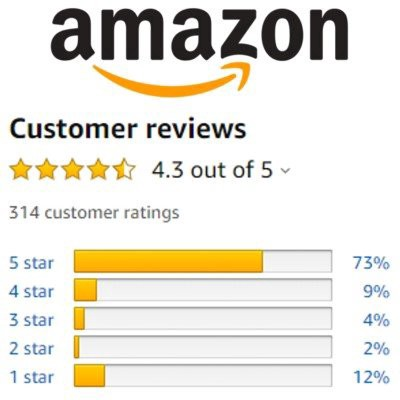

In [1]:
import pandas as pd

import math
import scipy.stats as st
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
df_ = pd.read_csv("amazon_review.csv")

In [4]:
df = df_.copy()

### Veri Seti Hikayesi
#### reviewerID:           Kullanıcı ID’si
#### asin:                      Ürün ID’si
#### reviewerName:     Kullanıcı Adı
#### helpful:                  Faydalı değerlendirme derecesi
#### reviewText:           Değerlendirme 
#### overall:                  Ürün rating’i
#### summary:              Değerlendirme özeti
#### unixReviewTime:  Değerlendirme zamanı 
#### reviewTime:           Değerlendirme zamanı 
#### Rawday_diff:         Değerlendirmeden itibaren geçen gün sayısı
#### helpful_yes:         Değerlendirmenin faydalı bulunma sayısı
#### total_vote:            Değerlendirmeye verilen oy sayısı

In [5]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.00000,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.00000,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.00000,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.00000,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.00000,best deal around,1373673600,2013-07-13,513,0,0


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
overall,4915.00000,4.58759,0.99685,1.00000,5.00000,5.00000,5.00000,5.00000
unixReviewTime,4915.00000,1379465001.66836,15818574.32275,1339200000.00000,1365897600.00000,1381276800.00000,1392163200.00000,1406073600.00000
day_diff,4915.00000,437.36704,209.43987,1.00000,281.00000,431.00000,601.00000,1064.00000
helpful_yes,4915.00000,1.31109,41.61916,0.00000,0.00000,0.00000,0.00000,1952.00000
total_vote,4915.00000,1.52146,44.12309,0.00000,0.00000,0.00000,0.00000,2020.00000


In [7]:
df["total_vote"].value_counts()

0       4360
1        380
2         96
3         25
5         13
4         11
7          7
8          3
6          3
109        1
13         1
65         1
16         1
1694       1
139        1
25         1
10         1
1505       1
236        1
118        1
2020       1
68         1
495        1
48         1
21         1
49         1
Name: total_vote, dtype: int64

#### Ürün ortalama puanı

In [8]:
df["total_vote"].mean()

1.5214649033570702

In [9]:
df["reviewTime"] = pd.to_datetime(df["reviewTime"],dayfirst=True)

In [10]:
df["reviewTime"].max()

Timestamp('2014-12-07 00:00:00')

In [11]:
current_date = pd.to_datetime('2014-12-08 0:0:0')

In [12]:
df["days"] = (current_date - df["reviewTime"]).dt.days

In [14]:
df["days"].min()

1

#### Tarihe göre ağırlıklı puan ortalaması hesaplarsak;

In [16]:
q_1 = df["days"].quantile(0.25)
q_1

281.0

In [17]:
q_2 = df["days"].quantile(0.50)
q_2

431.0

In [18]:
q_3 = df["days"].quantile(0.75)
q_3

601.0

In [19]:
print(df.loc[(df["days"] <= 281), "overall"].mean())
print(df.loc[(df["days"] > 281) & (df["day_diff"] <= 431), "overall"].mean())
print(df.loc[(df["days"] > 431) & (df["day_diff"] <= 601), "overall"].mean())
print(df.loc[(df["days"] > 601), "overall"].mean())

4.6957928802588995
4.636140637775961
4.571661237785016
4.4462540716612375


#### Veri setinde yararlı ve yararlı olmayan oylar birliktedir . Bunları ayırmak için ; 

In [21]:
df["helpful_no"] = df["total_vote"] - df["helpful_yes"]

In [27]:
 def wilson_lower_bound(helpful_yes, helpful_no, confidence=0.95):
    """
    -Calculates the Wilson Lower Bound Score.
    -The lower limit of the confidence interval to be calculated for the Bernoulli parameter p is accepted as the WLB score.
    -The score to be calculated is used for product ranking.
    -Shows the marginal, taking into account the frequency and ratio information.
    Parameters
    ----------
    helpful_yes: int
        up count
    helpful_no: int
        down count
    confidence: float
        confidence interval for 95% confidence level
    Returns
    -------
    wilson score: float
    """
    n = helpful_yes + helpful_no
    if n == 0:
        return 0
    z = st.norm.ppf(1 - (1 - confidence) / 2)
    phat = 1.0 * helpful_yes / n
    return (phat + z * z / (2 * n) - z * math.sqrt((phat * (1 - phat) + z * z / (4 * n)) / n)) / (1 + z * z / n)

In [29]:
def score_up_down_diff(up, down):
    return up - down

In [30]:
def score_average_rating(up, down):
    if up + down == 0:
        return 0
    return up / (up + down)

In [32]:
df["score_pos_neg_diff"] = df.apply(lambda x: score_up_down_diff(x["helpful_yes"], x["helpful_no"]), axis=1)

df["score_average_rating"] = df.apply(lambda x: score_average_rating(x["helpful_yes"], x["helpful_no"]), axis=1)

df["wilson_lower_bound"] = df.apply(lambda x: wilson_lower_bound(x["helpful_yes"], x["helpful_no"]), axis=1)
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,days,helpful_no,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.00000,Four Stars,1406073600,2014-07-23,138,0,0,138,0,0,0.00000,0.00000
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.00000,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,409,0,0,0.00000,0.00000
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.00000,nothing to really say....,1356220800,2012-12-23,715,0,0,715,0,0,0.00000,0.00000
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.00000,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,382,0,0,0.00000,0.00000
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.00000,best deal around,1373673600,2013-07-13,513,0,0,513,0,0,0.00000,0.00000


#### According to Wilson_lower_bound, the first 20 comments; 

In [33]:
df.sort_values("wilson_lower_bound", ascending=False).head(20)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,days,helpful_no,score_pos_neg_diff,score_average_rating,wilson_lower_bound
2031,A12B7ZMXFI6IXY,B007WTAJTO,"Hyoun Kim ""Faluzure""","[1952, 2020]",[[ UPDATE - 6/19/2014 ]]So my lovely wife boug...,5.00000,UPDATED - Great w/ Galaxy S4 & Galaxy Tab 4 10...,1367366400,2013-01-05,702,1952,2020,702,68,1884,0.96634,0.95754
3449,AOEAD7DPLZE53,B007WTAJTO,NLee the Engineer,"[1428, 1505]",I have tested dozens of SDHC and micro-SDHC ca...,5.00000,Top of the class among all (budget-priced) mic...,1348617600,2012-09-26,803,1428,1505,803,77,1351,0.94884,0.93652
4212,AVBMZZAFEKO58,B007WTAJTO,SkincareCEO,"[1568, 1694]",NOTE: please read the last update (scroll to ...,1.00000,1 Star reviews - Micro SDXC card unmounts itse...,1375660800,2013-05-08,579,1568,1694,579,126,1442,0.92562,0.91214
317,A1ZQAQFYSXL5MQ,B007WTAJTO,"Amazon Customer ""Kelly""","[422, 495]","If your card gets hot enough to be painful, it...",1.00000,"Warning, read this!",1346544000,2012-02-09,1033,422,495,1033,73,349,0.85253,0.81858
4672,A2DKQQIZ793AV5,B007WTAJTO,Twister,"[45, 49]",Sandisk announcement of the first 128GB micro ...,5.00000,Super high capacity!!! Excellent price (on Am...,1394150400,2014-07-03,158,45,49,158,4,41,0.91837,0.80811
1835,A1J6VSUM80UAF8,B007WTAJTO,goconfigure,"[60, 68]",Bought from BestBuy online the day it was anno...,5.00000,I own it,1393545600,2014-02-28,283,60,68,283,8,52,0.88235,0.78465
3981,A1K91XXQ6ZEBQR,B007WTAJTO,"R. Sutton, Jr. ""RWSynergy""","[112, 139]",The last few days I have been diligently shopp...,5.00000,"Resolving confusion between ""Mobile Ultra"" and...",1350864000,2012-10-22,777,112,139,777,27,85,0.80576,0.73214
3807,AFGRMORWY2QNX,B007WTAJTO,R. Heisler,"[22, 25]",I bought this card to replace a lost 16 gig in...,3.00000,"Good buy for the money but wait, I had an issue!",1361923200,2013-02-27,649,22,25,649,3,19,0.88000,0.70044
4306,AOHXKM5URSKAB,B007WTAJTO,Stellar Eller,"[51, 65]","While I got this card as a ""deal of the day"" o...",5.00000,Awesome Card!,1339200000,2012-09-06,823,51,65,823,14,37,0.78462,0.67033
4596,A1WTQUOQ4WG9AI,B007WTAJTO,"Tom Henriksen ""Doggy Diner""","[82, 109]",Hi:I ordered two card and they arrived the nex...,1.00000,Designed incompatibility/Don't support SanDisk,1348272000,2012-09-22,807,82,109,807,27,55,0.75229,0.66359
